#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [3]:
import sys
!{sys.executable} -m pip install gdown h5py

In [4]:
# run this cell only the first time you run the notebook
run_this_cell = False
if run_this_cell:
    import gdown
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "data/IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)

In [5]:
# import useful libraries
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

### Load the data

In [6]:
path_to_data = 'data' 
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [7]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


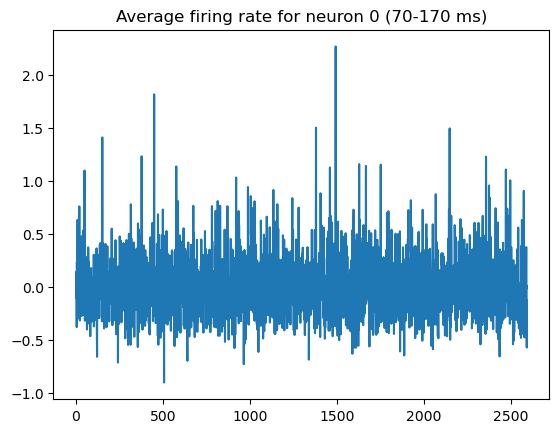

In [8]:
# we can now visualize the neuron response to the different stimuli
neuron_idx = 0

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
# note that each point represents average respose of the neuron over 100 ms to a different stimulus
# in fact there are 2592 peaks in the plot

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [9]:
from ridgecross import *

In [10]:
# transform objects to 8 classes and to int
objects_train_8 = transform_classes_to_int(transform_to_8_classes(objects_train))
objects_val_8 = transform_classes_to_int(transform_to_8_classes(objects_val))

# Flatten stimulus data
stimulus_train_res = stimulus_train.reshape((2592, -1))
stimulus_val_res = stimulus_val.reshape((288, -1))

# concatenate the 2 arrays
X_train = np.concatenate((stimulus_train_res, np.array(objects_train_8).reshape(-1,1)), axis=1)
X_val = np.concatenate((stimulus_val_res, np.array(objects_val_8).reshape(-1,1)), axis=1)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_val: ', X_val.shape)


Shape of X_train:  (2592, 150529)
Shape of X_val:  (288, 150529)


In [11]:
# one-hot encoding for the class labels
# number of classes
num_classes = 8

# one-hot encode the class labels
class_labels_one_hot = np.eye(num_classes)[X_train[:,-1].astype(int)]
class_labels_one_hot_val = np.eye(num_classes)[X_val[:,-1].astype(int)]

# concatenate the one-hot encoded labels to the feature matrix
X_train_augmented = np.hstack((X_train[:,:-1], class_labels_one_hot))
X_val_augmented = np.hstack((X_val[:,:-1], class_labels_one_hot_val))

In [ ]:
# fit ridge regression model to X_train after one-hot encoding the class labels

# fit ridge regression model to augmented data
model_weights, model_loss = ridge_regression(spikes_train, X_train_augmented, 10)

# make predictions using validation set
y_pred = np.dot(X_val_augmented, model_weights)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [10]:
# compute the explained variance
ev = 1- np.var(y_pred - spikes_val)/np.var(spikes_val)
print('Global exlained variance: ', ev)

# compute the ev for each neuron 
ev_per_neuron = 1- np.var(y_pred - spikes_val, axis=0)/np.var(spikes_val, axis=0)

# print histogram of ev per neuron
plt.hist(ev_per_neuron, bins=20)

NameError: name 'y_pred' is not defined

NameError: name 'y_val' is not defined

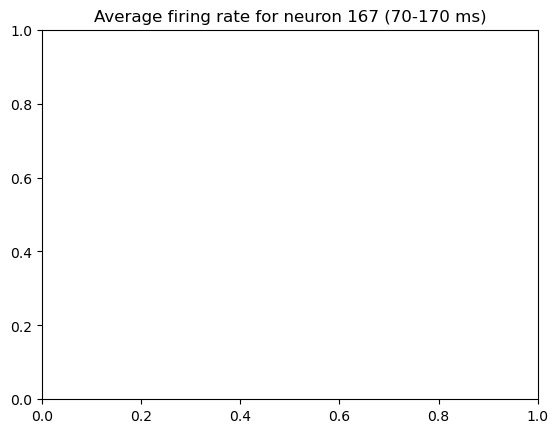

In [11]:
n_idx = 167
plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(n_idx))
plt.plot(y_val[:,n_idx], color='blue', label='true', linewidth=1)
plt.plot(y_pred_val[:,n_idx], color = 'red', alpha = 1, label='predicted', linewidth=.7)
plt.legend()


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [12]:
# perform PCA

n_comp = 1000

pca = PCA(n_components=n_comp)
pca.fit(stimulus_train_res)
pca_filters = pca.components_
pca_features_train = pca.transform(stimulus_train_res)
print(pca_features_train.shape)

# Take 1000 PCs for the validation set as well
pca_features_val = pca.transform(stimulus_val_res)
print(pca_features_val.shape)

# Now join them with the object_8 filters

pca_feature_matrix_8 = np.concatenate((pca_features_train, np.array(objects_train_8).reshape(-1,1)), axis=1)
print(pca_feature_matrix_8.shape)

# same for validation set
pca_feature_matrix_8_val = np.concatenate((pca_features_val, np.array(objects_val_8).reshape(-1,1)), axis=1)
print(pca_feature_matrix_8_val.shape)


(2592, 1000)
(288, 1000)
(2592, 1001)
(288, 1001)


In [13]:
# concatenate the one-hot encoded labels to the feature matrix
pca_feature_matrix_8_augmented = np.hstack((pca_feature_matrix_8[:,:-1], class_labels_one_hot))
pca_feature_matrix_8_val_augmented = np.hstack((pca_feature_matrix_8_val[:,:-1], class_labels_one_hot_val))

Overall explained variance:  0.07316179764669657
Overall correlation:  0.26774386638407793


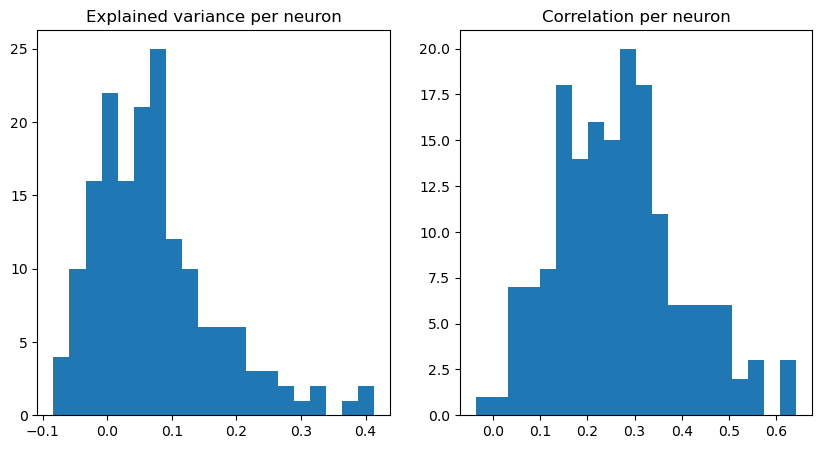

In [49]:
# fit ridge regression model with arbitrary lambda : 10

lamb = 10
model_weights, model_loss = ridge_regression(spikes_train, pca_feature_matrix_8_augmented, lamb)

# make predictions using validation set
class_labels_one_hot_val = np.eye(num_classes)[pca_feature_matrix_8_val[:,-1].astype(int)]
pca_feature_matrix_8_val_augmented = np.hstack((pca_feature_matrix_8_val[:,:-1], class_labels_one_hot_val))
y_pred = np.dot(pca_feature_matrix_8_val_augmented, model_weights)

# compute the ev for each neuron 
ev_per_neuron = 1- np.var(y_pred - spikes_val, axis=0)/np.var(spikes_val, axis=0)
# compute overall ev
ev = np.mean(ev_per_neuron)
print('Overall explained variance: ', ev)

# compute the correlation for each neuron
corr_per_neuron = np.array([np.corrcoef(y_pred[:,i], spikes_val[:,i], rowvar=False)[0,1] for i in range(y_pred.shape[1])])
# compute overall correlation
corr = np.mean(corr_per_neuron)
print('Overall correlation: ', corr)


# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of ev per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of corr per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [16]:

counts = [(el, objects_train_8.count(el) / len(objects_train_8)) for el in set(objects_train_8)] 
print(counts)

counts2 = [(el, objects_val_8.count(el) / len(objects_val_8)) for el in set(objects_val_8)]
print(counts2)

[(0, 0.12422839506172839), (1, 0.125), (2, 0.125), (3, 0.12422839506172839), (4, 0.1253858024691358), (5, 0.125), (6, 0.1253858024691358), (7, 0.1257716049382716)]
[(0, 0.13194444444444445), (1, 0.125), (2, 0.125), (3, 0.13194444444444445), (4, 0.12152777777777778), (5, 0.125), (6, 0.12152777777777778), (7, 0.11805555555555555)]


In [17]:
# grid-serach-CV

lambdas_candidates = np.array([1, 10, 100, 200, 500, 1000])

y = spikes_train
tX = pca_feature_matrix_8_augmented
seed = 42

k_fold = 5

opt_lambda, mse = select_parameters_ridge_regression(lambdas_candidates,k_fold, y, tX, seed)

                                                                  
print('Optimal lambdas per obj_class:',opt_lambda)


Optimal lambdas per obj_class: 200.0


Overall explained variance:  0.08702780823777356
Overall correlation:  0.2825454193761126


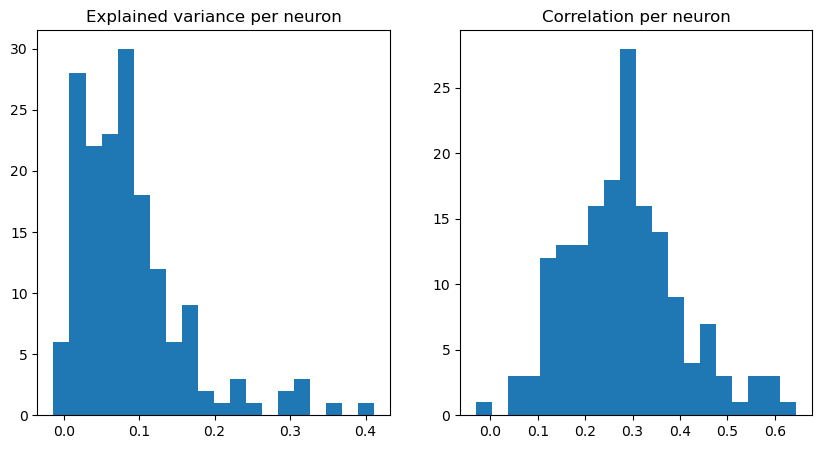

In [47]:
# fit ridge regression model with optimal lambda
model_weights, model_loss = ridge_regression(spikes_train, pca_feature_matrix_8_augmented, opt_lambda)

# make predictions using validation set
class_labels_one_hot_val = np.eye(num_classes)[pca_feature_matrix_8_val[:,-1].astype(int)]
pca_feature_matrix_8_val_augmented = np.hstack((pca_feature_matrix_8_val[:,:-1], class_labels_one_hot_val))
y_pred = np.dot(pca_feature_matrix_8_val_augmented, model_weights)


# compute the ev for each neuron 
ev_per_neuron = 1- np.var(y_pred - spikes_val, axis=0)/np.var(spikes_val, axis=0)
# compute overall ev
ev = np.mean(ev_per_neuron)
print('Overall explained variance: ', ev)

# compute the correlation for each neuron
corr_per_neuron = np.array([np.corrcoef(y_pred[:,i], spikes_val[:,i], rowvar=False)[0,1] for i in range(y_pred.shape[1])])
# compute overall correlation
corr = np.mean(corr_per_neuron)
print('Overall correlation: ', corr)


# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of ev per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of corr per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()


Overall explained variance:  0.12551622
Overall correlation:  0.3379114780721932


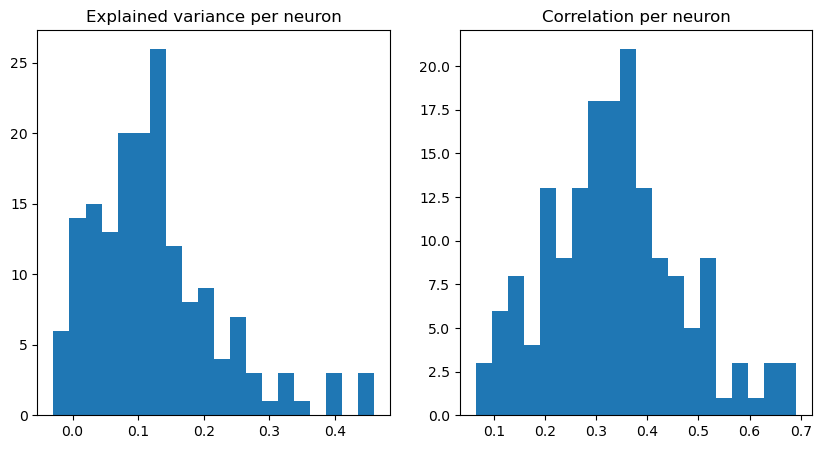

In [48]:
# although the explaind variance is higher, we can still do better:
# we can fit a ridge regression model for each class separately and 
# tune lambda for each class separately

# define num of classes
num_classes = 8

# create empty arrays to store model weights and losses for each class
model_weights_list = []
model_loss_list = []

lambdas = [1000.0, 100.0, 500.0, 1000.0, 200.0, 200.0, 100.0, 200.0]
# loop over each class
for class_num in range(num_classes):
    # extract data for current class
    class_indices = np.where(pca_feature_matrix_8[:,-1] == class_num)[0]
    class_X = pca_feature_matrix_8[class_indices,:-1]
    class_y = spikes_train[class_indices,:]
    
    # fit ridge regression model for current class
    class_weights, class_loss = ridge_regression(class_y, class_X, lambdas[class_num])
    
    # store model weights and losses for current class
    model_weights_list.append(class_weights)
    model_loss_list.append(class_loss)


# create empty array to store predicted values
y_pred = np.zeros_like(spikes_val)

# loop over each class
for class_num in range(num_classes):
    # extract data for current class
    class_indices = np.where(pca_feature_matrix_8_val[:,-1] == class_num)[0]
    class_X = pca_feature_matrix_8_val[class_indices,:-1]
    
    # make predictions using model weights for current class
    class_y_pred = np.dot(class_X, model_weights_list[class_num])
    
    # assign predicted values to appropriate indices in y_pred array
    y_pred[class_indices,:] = class_y_pred

# compute the ev for each neuron 
ev_per_neuron = 1- np.var(y_pred - spikes_val, axis=0)/np.var(spikes_val, axis=0)
# compute overall ev
ev = np.mean(ev_per_neuron)
print('Overall explained variance: ', ev)

# compute the correlation for each neuron
corr_per_neuron = np.array([np.corrcoef(y_pred[:,i], spikes_val[:,i], rowvar=False)[0,1] for i in range(y_pred.shape[1])])
# compute overall correlation
corr = np.mean(corr_per_neuron)
print('Overall correlation: ', corr)


# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# print histogram of ev per neuron
ax = axs[0]
ax.hist(ev_per_neuron, bins=20)
ax.set_title('Explained variance per neuron')

# print histogram of corr per neuron
ax = axs[1]
ax.hist(corr_per_neuron, bins=20)
ax.set_title('Correlation per neuron')

plt.show()


### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.eval()

In [ ]:
# placeholder
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

what the TA said: 

for all the layers hook one then loop through the images

remove the hook before going to another layer (every layer we do erase the results of the previous one on the hook)

In [ ]:
# placeholders for predictions and features
PREDS = []
FEATS = []

layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']
for name in layers:
    model.register_forward_hook(get_features(name))
    
    for image in stimulus_test:
        # forward pass [with feature extraction]
        x = np.expand_dims(image, axis=0)
        preds = model(torch.tensor(x))
    
        # add feats and preds to lists
        PREDS.append(preds.detach().cpu().numpy())
        FEATS.append(features[name].cpu().numpy())
    # hooked.remove honestly don't know how to do that => also maybe store the results in different arrays?